In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import pandas as pd
import numpy as np
from glob import glob
from os.path import join
from tqdm import tqdm
from matplotlib.colors import LogNorm

import strawb
from strawb.tools import wavelength_to_rgb

import seaborn as sns


In [3]:
matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../no_git/style.mplstyle")
colorlist = plt.rcParams["axes.prop_cycle"].by_key()["color"]


# Setup

In [4]:
# load DB
db = strawb.SyncDBHandler(file_name="Default")  # loads the db


In [5]:
### these are the available device codes
print(db.dataframe.deviceCode.unique())

### different measurement types for PMTSPEC and LIDAR
print(db.dataframe.measurement_type.unique())


['ONCMJB016' 'TUMLIDAR001' 'TUMLIDAR002' 'TUMMINISPECTROMETER001'
 'TUMMUONTRACKER001' 'TUMPMTSPECTROMETER001' 'TUMPMTSPECTROMETER002'
 'TUMSTANDARDMODULE001' 'TUMSTANDARDMODULE004']
[nan 'counts' 'rate_scan' 'basic']


## select time range

In [6]:
mask = db.dataframe["deviceCode"] == "TUMPMTSPECTROMETER001"
mask &= db.dataframe["dataProductCode"] == "PMTSD"

timestamp = np.datetime64("2021-09-01T00:00:00")
mask &= db.dataframe.dateFrom >= pd.Timestamp(np.datetime64(timestamp, "h"), tz="UTC")
mask &= db.dataframe.dateFrom < pd.Timestamp(
    np.datetime64(timestamp, "h"), tz="UTC"
) + np.timedelta64(5, "D")


In [7]:
### see which files are synced
np.count_nonzero(db.dataframe[mask].synced), len(db.dataframe[mask])


(130, 130)

set up a column to track which files are known to be ok, or which files are known to be eg. corrupt

if not "file_ok" in db.dataframe:
    db.dataframe["file_ok"] = "None"

## download missing files

In [8]:
# check if files will be downloaded
if not db.dataframe.synced[mask].all():
    print("Files will be downloaded")
else:
    print("No files will be downloaded")


No files will be downloaded


In [9]:
### this will download the selected files
if not db.dataframe.synced[mask].all():
    db.update_db_and_load_files(
        db.dataframe[mask],
        output=True,  # print output to console
        download=True,  # download the files
        # save_db=True
    )
    db.save_db()


In [10]:
# mask by device
mask = db.dataframe["deviceCode"] == "TUMPMTSPECTROMETER001"
mask &= db.dataframe["dataProductCode"] == "PMTSD"

# and add mask by 'measurement_type'
mask &= db.dataframe.measurement_type.isnull() | (
    db.dataframe.measurement_type == "counts"
)
mask &= db.dataframe["synced"]


In [11]:
db.dataframe[mask].head()  # plot the table with available PMTSPEC files


,archiveLocation,archivedDate,compression,dataProductCode,dateFrom,dateTo,deviceCode,fileSize,filename,modifyDate,...,name,previous_file_id,rollover_interval,run_end,run_start,write_period,measurement_type,measurement_duration,write_period_jitter,file_ok
fullPath,,,,,,,,,,,,,,,,,,,,,
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T000000.000Z-SDAQ-PMTSPEC.hdf5,/NA_Archive_04,2021-09-01 02:09:41.650000+00:00,None,PMTSD,2021-09-01 00:00:00+00:00,2021-09-01 00:59:59.999000+00:00,TUMPMTSPECTROMETER001,31861355,TUMPMTSPECTROMETER001_20210901T000000.000Z-SDA...,2021-09-01 02:09:43.402000+00:00,...,PMTSPEC,3.622651e+18,{'hours': 1},NaT,2021-08-31 03:08:04.986227036+00:00,60.0,counts,NaN,NaN,ok
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T010000.000Z-SDAQ-PMTSPEC.hdf5,/NA_Archive_04,2021-09-02 01:50:13.216000+00:00,None,PMTSD,2021-09-01 01:00:00+00:00,2021-09-01 01:59:59.999000+00:00,TUMPMTSPECTROMETER001,17324748,TUMPMTSPECTROMETER001_20210901T010000.000Z-SDA...,2021-09-02 01:50:13.720000+00:00,...,PMTSPEC,1.508277e+19,{'hours': 1},NaT,2021-08-31 03:08:04.986227036+00:00,60.0,counts,NaN,NaN,ok
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T020000.000Z-SDAQ-PMTSPEC.hdf5,/NA_Archive_04,2021-09-02 01:50:16.651000+00:00,None,PMTSD,2021-09-01 02:00:00+00:00,2021-09-01 02:59:59.999000+00:00,TUMPMTSPECTROMETER001,46204,TUMPMTSPECTROMETER001_20210901T020000.000Z-SDA...,2021-09-02 01:50:16.678000+00:00,...,PMTSPEC,1.705897e+19,{'hours': 1},NaT,2021-08-31 03:08:04.986227036+00:00,60.0,counts,NaN,NaN,corrupt
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T030000.000Z-SDAQ-PMTSPEC.hdf5,/NA_Archive_04,2021-09-02 01:50:32.796000+00:00,None,PMTSD,2021-09-01 03:00:00+00:00,2021-09-01 03:01:00.243000+00:00,TUMPMTSPECTROMETER001,39994,TUMPMTSPECTROMETER001_20210901T030000.000Z-SDA...,2021-09-02 01:50:32.815000+00:00,...,PMTSPEC,1.411401e+19,{'hours': 1},NaT,2021-08-31 03:08:04.986227036+00:00,60.0,counts,NaN,NaN,corrupt
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T030758.986Z-SDAQ-PMTSPEC.hdf5,/NA_Archive_04,2021-09-02 01:50:34.810000+00:00,None,PMTSD,2021-09-01 03:07:58.986000+00:00,2021-09-01 03:59:59.999000+00:00,TUMPMTSPECTROMETER001,26586245,TUMPMTSPECTROMETER001_20210901T030758.986Z-SDA...,2021-09-02 01:50:35.488000+00:00,...,PMTSPEC,0.000000e+00,{'hours': 1},NaT,2021-09-01 03:07:58.987215042+00:00,60.0,counts,NaN,NaN,ok


In [12]:
db.dataframe[mask]["file_ok"].head()


fullPath
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T000000.000Z-SDAQ-PMTSPEC.hdf5         ok
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T010000.000Z-SDAQ-PMTSPEC.hdf5         ok
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T020000.000Z-SDAQ-PMTSPEC.hdf5    corrupt
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T030000.000Z-SDAQ-PMTSPEC.hdf5    corrupt
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T030758.986Z-SDAQ-PMTSPEC.hdf5         ok
Name: file_ok, dtype: object

# Rate counting

## load or read data

In [15]:
good_trb_series = pd.read_pickle(
    "/data/straw_b/processed_data/pmtspectrometer001/dataframes/20210901_good_trb_series.pickle"
)


In [99]:
mask = np.array([True, True, False, True, False])
weights = np.random.uniform(size=len(mask))
np.count_nonzero(mask), weights


(3, array([0.250234  , 0.31624241, 0.62954992, 0.04981438, 0.4534342 ]))

In [164]:
good_trb_series = []
# select file with the right data
mask = db.dataframe.deviceCode == "TUMPMTSPECTROMETER001"
mask &= db.dataframe.dataProductCode == "PMTSD"
mask &= db.dataframe.measurement_type.isnull() | (
    db.dataframe.measurement_type == "counts"
)
# only synced data
mask &= db.dataframe.synced
# load PMTSpec
for i, row in db.dataframe[mask].iterrows():
    if row.file_ok == "corrupt" or row.file_ok == "empty":
        continue
    try:
        ## get the PMT data and its meta data (channel no. etc)
        pmt_specs_timeseries = strawb.sensors.PMTSpec(row.filename)
        meta = pmt_specs_timeseries.pmt_meta_data.channel_meta_array
        ## select the channel with no wavelength filter
        no_filter_ind = meta[meta["wavelength"] == 0]["index"][0]
        selection = pmt_specs_timeseries.trb_rates.rate[no_filter_ind]
    except KeyError:
        # corrupt file
        print("Corrupt file:", row.filename)
        db.dataframe.loc[i, "file_ok"] = "corrupt"
        continue
    except TypeError as e:
        # empty file
        print("Empty file:", row.filename)
        db.dataframe.loc[i, "file_ok"] = "empty"
        continue

    ## build a histogram of the rate series
    bins = np.linspace(0, 8, 100)
    mask = selection > 0
    # leave first bin as underflow
    h, ed = np.histogram(np.log10(selection[mask]), bins=bins)
    ## ... and a histogram weighted with the size of the time intervals
    weights = pmt_specs_timeseries.trb_rates._rate_delta_t
    hw, _ = np.histogram(
        np.log10(selection[mask]),
        bins=bins,
        weights=weights[mask],  # / np.sum(weights[mask]),
    )
    # check that the first bin for underflow is zero
    assert h[0] == 0
    assert hw[0] == 0
    # add zero counts as first "underflow" bin
    h[0] = np.count_nonzero(~mask)
    hw[0] = np.sum(weights[~mask])
    good_trb_series.append(
        {
            "rate_hist": h,
            "weighted_rate_hist": hw,
            "rate_bins": bins,
            "zero_counts": h[0],  # total zero counts
            "weighted_zero_counts": hw[0],  # zero counts weighted with time interval
            "timestamp": pd.Timestamp(row.dateFrom),
        }
    )
    db.dataframe.loc[i, "file_ok"] = "ok"
good_trb_series = pd.DataFrame(good_trb_series)
db.save_db()
good_trb_series.to_pickle(
    "/data/straw_b/processed_data/pmtspectrometer001/dataframes/20210901_good_trb_series.pickle"
)


In [165]:
good_trb_series


,rate_hist,weighted_rate_hist,rate_bins,zero_counts,weighted_zero_counts,timestamp
0,"[2176189, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2089.6796, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.08080808080808081, 0.16161616161616163...",2176189,2089.6796,2021-09-01 00:00:00+00:00
1,"[1025891, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[968.8295000000005, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.08080808080808081, 0.16161616161616163...",1025891,968.8295,2021-09-01 01:00:00+00:00
2,"[2016722, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1946.057800000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.08080808080808081, 0.16161616161616163...",2016722,1946.0578,2021-09-01 03:07:58.986000+00:00
3,"[2860286, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2767.8134999999984, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.08080808080808081, 0.16161616161616163...",2860286,2767.8135,2021-09-01 04:00:00+00:00
4,"[2888939, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2795.705400000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.08080808080808081, 0.16161616161616163...",2888939,2795.7054,2021-09-01 05:00:00+00:00
...,...,...,...,...,...,...
120,"[2727640, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2698.174100000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.08080808080808081, 0.16161616161616163...",2727640,2698.1741,2021-09-05 21:00:00+00:00
121,"[2839975, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2811.0352000000003, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.08080808080808081, 0.16161616161616163...",2839975,2811.0352,2021-09-05 22:00:00+00:00
122,"[2647133, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2617.408900000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.08080808080808081, 0.16161616161616163...",2647133,2617.4089,2021-09-05 23:00:00+00:00
123,"[1866824, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1787.9307, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.08080808080808081, 0.16161616161616163...",1866824,1787.9307,2021-09-14 12:00:00+00:00


In [16]:
db.dataframe[
    (db.dataframe.file_ok == "corrupt") | (db.dataframe.file_ok == "empty")
].fileSize


fullPath
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T020000.000Z-SDAQ-PMTSPEC.hdf5    46204
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T030000.000Z-SDAQ-PMTSPEC.hdf5    39994
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210926T030000.000Z-SDAQ-PMTSPEC.hdf5    39999
Name: fileSize, dtype: int64

## histogram helpers

In [179]:
def interpolate_quantile_value(q, xedges, yvals, offset=0, offset_type="underflow", verbose=False):
    r"""Interpolate quantile values from a histogram.

    Parameters:
    -----------
    q: quantile, float between 0 and 1
    xedges: bin edges of the histogram with length n+1
    yvals: heights of the bins with length n
    offset: account for a low offset/underflow bin not in yvals
    offset_type: 'underflow', 'overflow'
    verbose: returns also the coordinates used for interpolation

    Returns:
    --------
    Quantile value based on interpolated histogram values,
    verbose=True: x and y coordinates of 2 points used for interpolation
    """
    cumulative_yvals = np.cumsum(yvals).astype(float) 
    if offset_type == 'underflow':
        cumulative_yvals += offset
        cumulative_yvals /= np.max(cumulative_yvals)
    elif offset_type == 'overflow':
        cumulative_yvals /= offset

    mids = (xedges[:-1] + xedges[1:]) * 0.5
    mask_s = cumulative_yvals <= q 
    mask_l = cumulative_yvals > q
    try:
        x1 = np.atleast_1d(mids[mask_s])[-1]
        x2 = np.atleast_1d(mids[mask_l])[0]
        y1 = np.atleast_1d(cumulative_yvals[mask_s])[-1]
        y2 = np.atleast_1d(cumulative_yvals[mask_l])[0]
    except:
        # this means the quantile is either in the lowest or the highest bin
        if np.count_nonzero(mask_s) == 0:
            print("Quantile is in lowest bin")
            return xedges[0]
        elif np.count_nonzero(mask_l) == 0:
            print("Quantile is in highest bin")
            return xedges[1:][yvals > 0][-1]
        else:
            print("Something weird happened??? Please check")
            return None
    if verbose:
        # we want to have the x-value to the quantile,
        # so we need to switch x and y here
        return np.interp(q, [y1, y2], [x1, x2]), [y1, y2], [x1, x2]
    else:
        return np.interp(q, [y1, y2], [x1, x2])


In [180]:
def histplot_from_nphist(h, ed, nfig=1, **kwargs):
    r"""Make a histogram plot from np.histogram values 'h' and edges 'ed'."""
    plt.figure(nfig)
    plt.plot(
        np.concatenate([[ed[0]], ed, [ed[-1]]]),
        np.concatenate([[0], h, [h[-1], 0]]),
        ds="steps-post",
        **kwargs
    )


## test histogram helpers

-0.268749783674475
-0.32137456579808416
Quantile is in lowest bin
-2.198325128206811


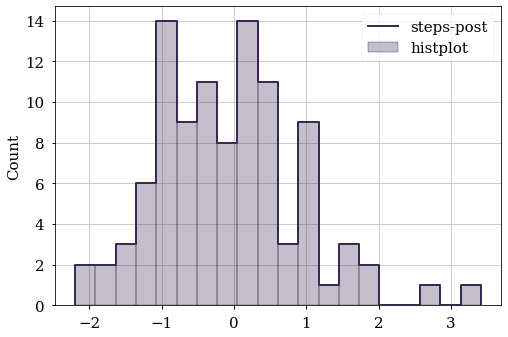

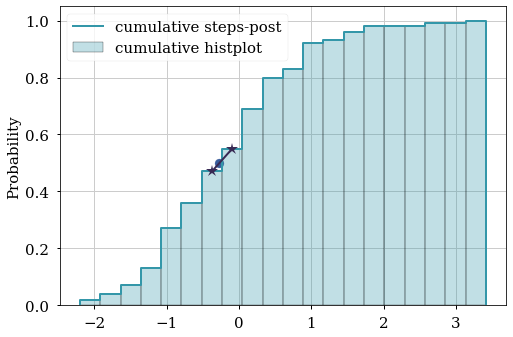

In [181]:
bins = 20  # np.linspace(-3, 3, 25)
rand = np.random.normal(size=100)
h, ed = np.histogram(rand, bins=bins)
histplot_from_nphist(h, ed, label="steps-post")
sns.histplot(rand, bins=ed, label="histplot", alpha=0.3)
plt.legend()

ch = np.cumsum(h) / np.sum(h)
histplot_from_nphist(
    ch,
    ed,
    nfig=2,
    label="cumulative steps-post",
    color=colorlist[2],
)
sns.histplot(
    rand,
    bins=ed,
    label="cumulative histplot",
    alpha=0.3,
    cumulative=True,
    color=colorlist[2],
    stat="probability",
)

q = 0.5
val, yy, xx = interpolate_quantile_value(q, ed, h, verbose=True)
print(val)
plt.plot(xx, yy, marker="*", ms=12)
plt.scatter(val, q, s=80)
plt.legend()

val = interpolate_quantile_value(q, ed, h, offset=3, offset_type="underflow")
print(val)

val = interpolate_quantile_value(q, ed, h, offset=3, offset_type="overflow")
print(val)


## rate plots

Quantile is in lowest bin
Quantile is in lowest bin


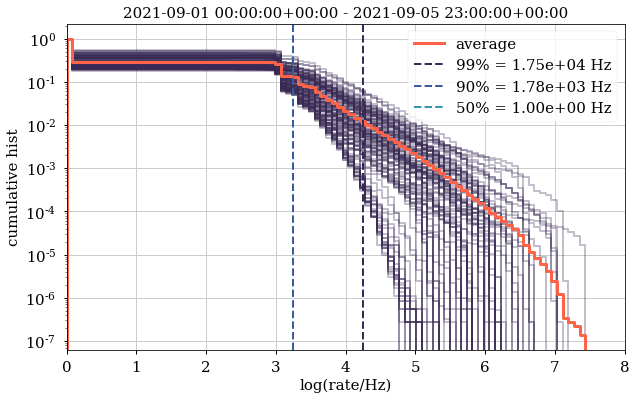

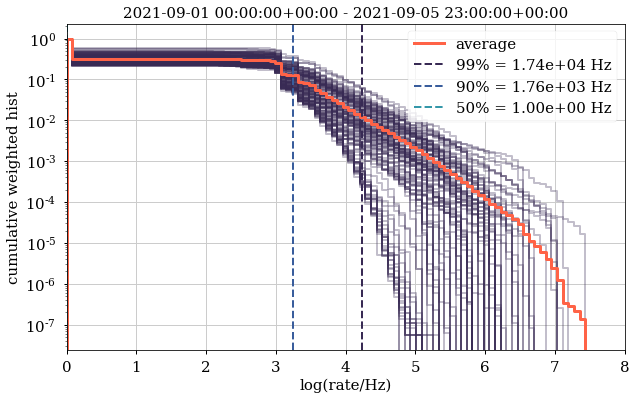

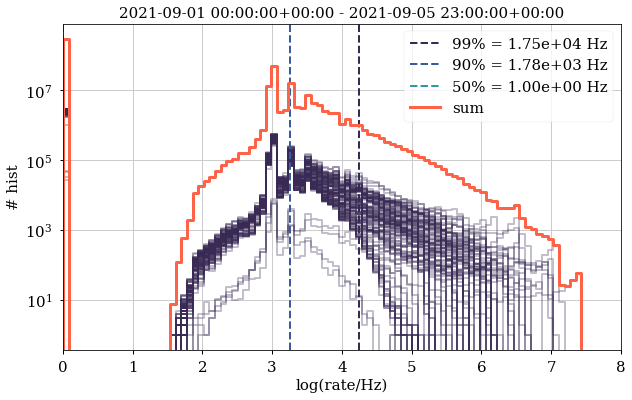

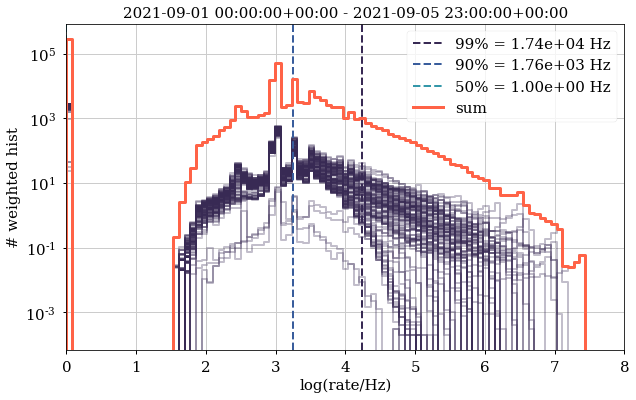

In [186]:
## total rates, cumulative rates, per hour
plt.figure(1, figsize=(10, 6))
plt.figure(2, figsize=(10, 6))
plt.figure(3, figsize=(10, 6))
plt.figure(4, figsize=(10, 6))

timestamp = np.datetime64("2021-09-06T00:00:00")
mask = good_trb_series.timestamp <= pd.Timestamp(timestamp, tz="utc")

for _, trb in good_trb_series[mask].iterrows():
    ## cumulative rate hist
    cs = np.cumsum(trb.rate_hist[::-1]).astype(float)
    cs /= cs[-1]
    histplot_from_nphist(cs[::-1], trb.rate_bins, nfig=1, alpha=0.3, color=colorlist[0])
    ## cumulative weighted rate hist
    cs = (
        np.cumsum(trb.weighted_rate_hist[::-1]).astype(float)
    )
    cs /= cs[-1]
    histplot_from_nphist(cs[::-1], trb.rate_bins, nfig=2, alpha=0.3, color=colorlist[0])
    ## rate hist
    histplot_from_nphist(
        trb.rate_hist, trb.rate_bins, nfig=3, alpha=0.3, color=colorlist[0]
    )
    # point plot for zero rates
    # plt.scatter(-0.5 + 0.1 * _, trb.zero_counts, color=colorlist[0])
    ## weighted rate hist
    histplot_from_nphist(
        trb.weighted_rate_hist, trb.rate_bins, nfig=4, alpha=0.3, color=colorlist[0]
    )
    # point plot for zero rates
    # plt.scatter(-0.5 + 0.1 * _, trb.zero_counts, color=colorlist[0])

rate_sum = good_trb_series.rate_hist.sum()
cs = np.cumsum(rate_sum[::-1]).astype(float)
cs /= cs[-1]
histplot_from_nphist(
    cs[::-1], trb.rate_bins, nfig=1, label="average", color="tomato", lw=3
)

weighted_rate_sum = good_trb_series.weighted_rate_hist.sum()
wcs = np.cumsum(weighted_rate_sum[::-1]).astype(float)
wcs /= wcs[-1]
histplot_from_nphist(
    wcs[::-1], trb.rate_bins, nfig=2, label="average", color="tomato", lw=3
)

quantiles = [0.99, 0.9, 0.5]
for i, q in enumerate(quantiles):
    thresh = interpolate_quantile_value(
        q, trb.rate_bins, rate_sum
    )
    if thresh is not None:
        plt.figure(1)
        plt.axvline(
            thresh,
            label=f"{int(q*100)}% = {10**thresh:1.2e} Hz",
            ls="--",
            color=colorlist[i % len(colorlist)],
        )
        plt.figure(3)
        plt.axvline(
            thresh,
            label=f"{int(q*100)}% = {10**thresh:1.2e} Hz",
            ls="--",
            color=colorlist[i % len(colorlist)],
        )

    thresh = interpolate_quantile_value(
        q,
        trb.rate_bins,
        weighted_rate_sum,
        # offset=good_trb_series.weighted_zero_counts.sum(),
    )
    if thresh is not None:
        plt.figure(2)
        plt.axvline(
            thresh,
            label=f"{int(q*100)}% = {10**thresh:1.2e} Hz",
            ls="--",
            color=colorlist[i % len(colorlist)],
        )
        plt.figure(4)
        plt.axvline(
            thresh,
            label=f"{int(q*100)}% = {10**thresh:1.2e} Hz",
            ls="--",
            color=colorlist[i % len(colorlist)],
        )

histplot_from_nphist(rate_sum, trb.rate_bins, nfig=3, label="sum", color="tomato", lw=3)
# plt.scatter(-0.5 + 0.1 * (_ + 1), trb.zero_counts, color="tomato")
histplot_from_nphist(
    weighted_rate_sum, trb.rate_bins, nfig=4, label="sum", color="tomato", lw=3
)
# plt.scatter(-0.5 + 0.1 * (_ + 1), trb.zero_counts, color="tomato")


plt.figure(1)
plt.xlim(0, 8)
plt.ylabel("cumulative hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.savefig("../no_git/plot_dump/cumulative_rate.png", bbox_inches='tight')

plt.figure(2)
plt.xlim(0, 8)
plt.ylabel("cumulative weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.savefig("../no_git/plot_dump/weighted_cumulative_rate.png", bbox_inches='tight')

plt.figure(3)
plt.xlim(0, 8)
plt.ylabel("# hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.savefig("../no_git/plot_dump/rate.png", bbox_inches='tight')

plt.figure(4)
plt.xlim(0, 8)
plt.ylabel("# weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.savefig("../no_git/plot_dump/weighted_rate.png", bbox_inches='tight')


In [189]:
## percentiles of rate per hour
# plt.figure(1, figsize=(10, 6))

quantiles = [0.9, 0.99]
quantile_values = []
for _, trb in good_trb_series.iterrows():
    tmp = {"timestamp": trb.timestamp}
    for q in quantiles:
        tmp[f"q_{int(q*100)}"] = interpolate_quantile_value(
            q, trb.rate_bins, trb.rate_hist
        )
        tmp[f"q_{int(q*100)}_weighted"] = interpolate_quantile_value(
            q, trb.rate_bins, trb.weighted_rate_hist
        )
    quantile_values.append(tmp)
quantile_values = pd.DataFrame(quantile_values)
quantile_values


,timestamp,q_90,q_90_weighted,q_99,q_99_weighted
0,2021-09-01 00:00:00+00:00,3.547535,3.540838,4.628688,4.619273
1,2021-09-01 01:00:00+00:00,3.707586,3.693914,4.615772,4.596714
2,2021-09-01 03:07:58.986000+00:00,3.486387,3.482176,4.524019,4.518970
3,2021-09-01 04:00:00+00:00,3.008752,3.006545,3.681140,3.670955
4,2021-09-01 05:00:00+00:00,3.003470,3.001081,3.614359,3.600539
...,...,...,...,...,...
120,2021-09-05 21:00:00+00:00,3.025892,3.024959,3.984263,3.979812
121,2021-09-05 22:00:00+00:00,3.007720,3.006413,3.640937,3.636578
122,2021-09-05 23:00:00+00:00,3.186528,3.174346,3.940568,3.934708
123,2021-09-14 12:00:00+00:00,3.659272,3.653725,4.659461,4.657753


In [201]:
quantile_values.timestamp[0].hour

0

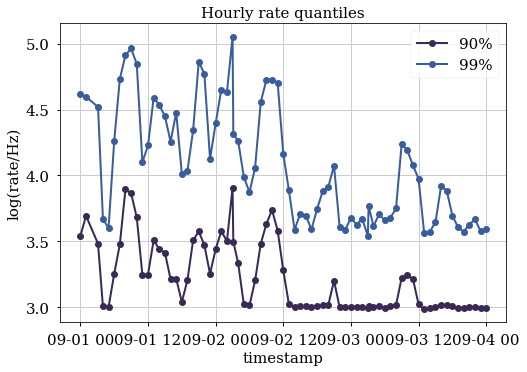

In [204]:
timestamp = np.datetime64("2021-09-04T00:00:00")
mask = quantile_values.timestamp <= pd.Timestamp(timestamp, tz="utc")
plt.plot(
    quantile_values.timestamp[mask],
    #f"day {quantile_values.timestamp[mask].day}, {quantile_values.timestamp[mask].hour} h",
    quantile_values.q_90_weighted[mask],
    marker="o",
    label="90%",
)
plt.plot(
    quantile_values.timestamp[mask],
    #f"day {quantile_values.timestamp[mask].day}, {quantile_values.timestamp[mask].hour} h",
    quantile_values.q_99_weighted[mask],
    marker="o",
    label="99%",
)
plt.ylabel("log(rate/Hz)")
plt.xlabel("timestamp")
plt.title("Hourly rate quantiles")
plt.legend()
plt.savefig("../no_git/plot_dump/rate_quantiles_per_hour.png")

In [ ]:
rate_sum = good_trb_series.rate_hist.sum()
weighted_rate_sum = good_trb_series.weighted_rate_hist.sum()

cs = np.cumsum(rate_sum[::-1]).astype(float)
cs /= cs[-1]
wcs = np.cumsum(weighted_rate_sum[::-1]).astype(float)
wcs /= wcs[-1]

for q in quantiles:
    mids = (trb.rate_bins[:-1] + trb.rate_bins[1:]) * 0.5
    thresh = mids[cs[::-1] >= q][-1]
    plt.figure(1)
    plt.axvline(thresh, label=f"{q*100} %", ls="--", lw=1)
    plt.figure(3)
    plt.axvline(thresh, label=f"{q*100} %", ls="--", lw=1)

    thresh = mids[wcs[::-1] >= q][-1]
    plt.figure(2)
    plt.axvline(thresh, label=f"{q*100} %", ls="--", lw=1)
    plt.figure(4)
    plt.axvline(thresh, label=f"{q*100} %", ls="--", lw=1)


plt.ylabel("# weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=1, ncol=1)
# plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1)
plt.semilogy()
plt.title(f"{good_trb_series.timestamp.min()} - {good_trb_series.timestamp.max()}")


# Analyze specific events

In [205]:
selected_timestamps = [
    np.datetime64("2021-09-04T23:44:09"),
    np.datetime64("2021-09-14T12:11:46"),
    np.datetime64("2021-09-26T03:14:35"),
]


In [206]:
for timestamp in selected_timestamps:
    mask = db.dataframe["deviceCode"] == "TUMPMTSPECTROMETER001"
    mask &= db.dataframe["dataProductCode"] == "PMTSD"
    ## select 1h frame around the selected timestamps
    mask &= db.dataframe.dateFrom >= pd.Timestamp(
        np.datetime64(timestamp, "h"), tz="UTC"
    )
    mask &= db.dataframe.dateFrom < (
        pd.Timestamp(np.datetime64(timestamp, "h"), tz="UTC") + np.timedelta64(1, "h")
    )
    if not db.dataframe.synced[mask].all():
        db.update_db_and_load_files(
            db.dataframe[mask],
            output=True,  # print output to console
            download=True,  # download the files
            # save_db=True
        )
        db.save_db()


In [207]:
pmt_specs = []
for timestamp in selected_timestamps:
    # select file with the right data
    mask = db.dataframe.deviceCode == "TUMPMTSPECTROMETER001"
    mask &= db.dataframe.dataProductCode == "PMTSD"
    mask &= db.dataframe.measurement_type.isnull() | (
        db.dataframe.measurement_type == "counts"
    )
    # only synced data
    mask &= db.dataframe.synced

    ## select 1h frame around the biolumi event
    mask &= db.dataframe.dateFrom >= pd.Timestamp(
        np.datetime64(timestamp, "h"), tz="UTC"
    )
    mask &= db.dataframe.dateFrom < pd.Timestamp(
        np.datetime64(timestamp, "h"), tz="UTC"
    ) + np.timedelta64(1, "h")

    # load PMTSpec
    try:
        # select the latest frame that matches the condition
        pmt_specs.append(strawb.sensors.PMTSpec(db.dataframe.filename[mask].iloc[-1]))
        print("that did actually work!")
    except:
        print("that didnt work", db.dataframe.filename[mask].iloc[-1])
        continue


that did actually work!
that did actually work!
that did actually work!


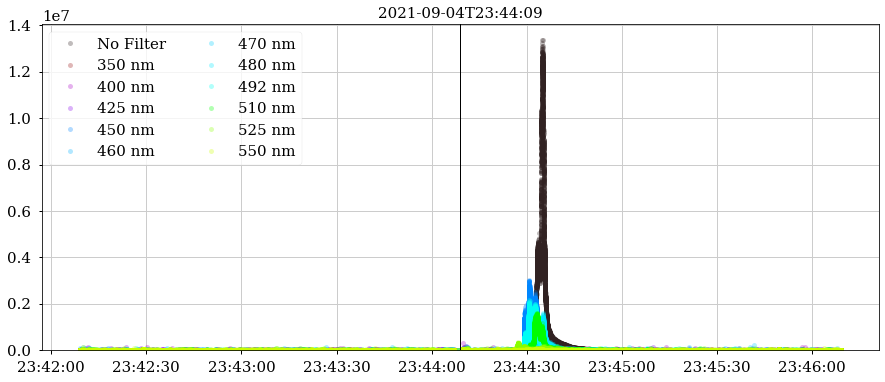

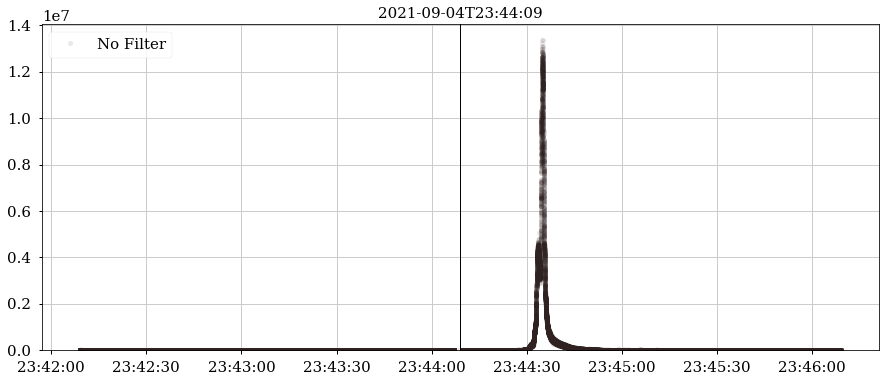

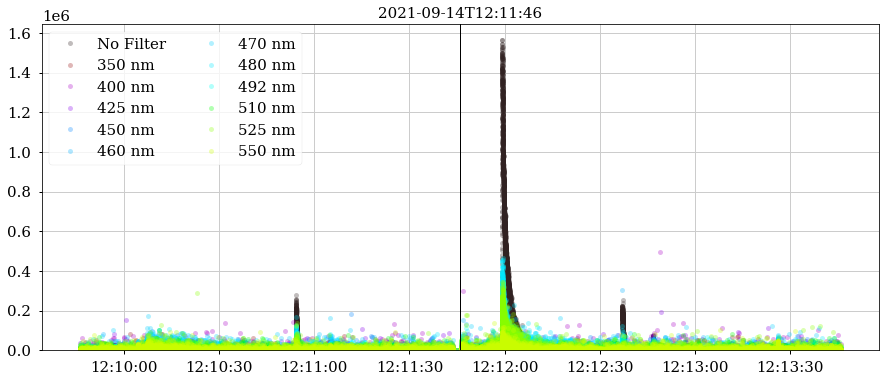

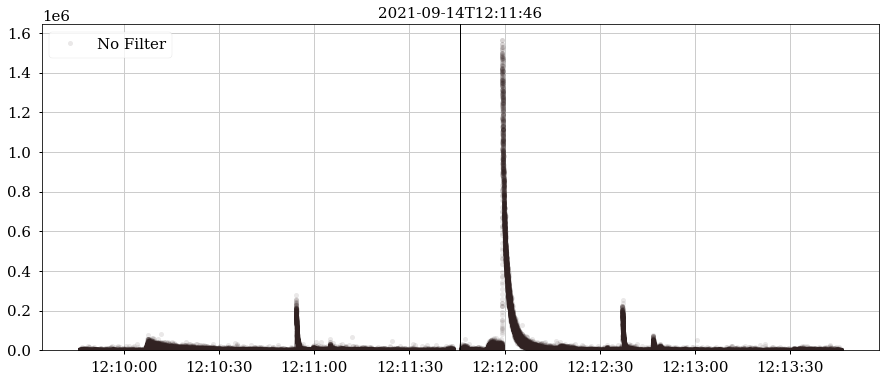

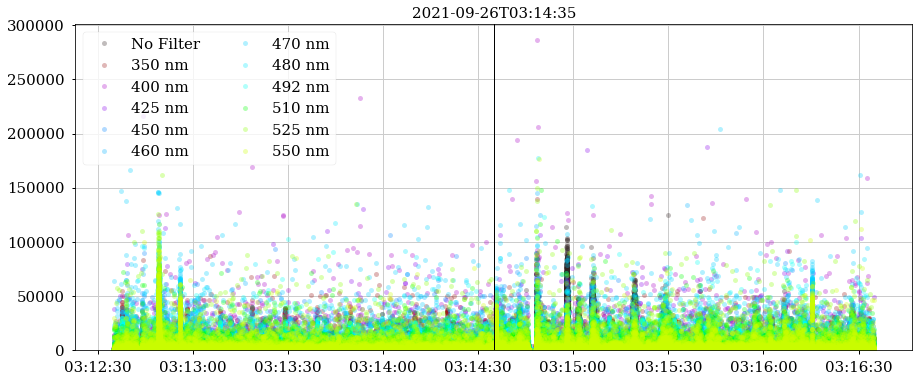

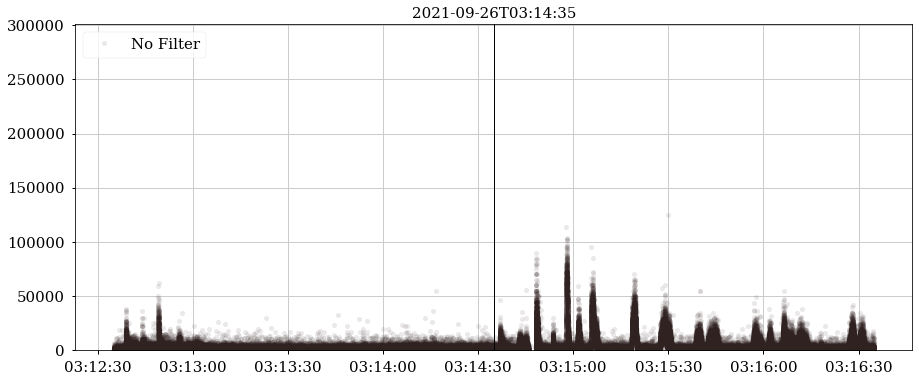

In [208]:
for pmtspec, timestamp in zip(pmt_specs, selected_timestamps):

    pmtspec.pmt_meta_data.add_colors(
        plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
    )

    times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
    ### select +-2min around biolumi events
    timemask = times_ns >= timestamp - np.timedelta64(
        2, "m"
    )  # - np.timedelta64(30, "s")
    timemask &= times_ns <= timestamp + np.timedelta64(
        2, "m"
    )  # + np.timedelta64(30, "s")
    masked_times_ns = times_ns[timemask]

    plt.figure(figsize=(15, 6))
    plt.title(timestamp)
    for ch in pmtspec.pmt_meta_data.channel_meta_array:
        _ = plt.plot(
            masked_times_ns,
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
            color=wavelength_to_rgb(ch, gamma=0.4),
            label=ch["label"],
            marker="o",
            lw=0,
            alpha=0.3,
            ms=5,
        )
    plt.legend(loc=2, ncol=2)
    plt.axvline(timestamp, lw=1, color="k")
    plt.ylim(0, np.max(pmtspec.trb_rates.rate.T[timemask]) * 1.05)

    plt.figure(figsize=(15, 6))
    plt.title(timestamp)
    for ch in pmtspec.pmt_meta_data.channel_meta_array[
        pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
    ]:
        _ = plt.plot(
            masked_times_ns,
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
            color=wavelength_to_rgb(ch, gamma=0.4),
            label=ch["label"],
            marker="o",
            lw=0,
            alpha=0.1,
            ms=5,
        )
    plt.legend(loc=2, ncol=2)
    plt.axvline(timestamp, lw=1, color="k")
    plt.ylim(0, np.max(pmtspec.trb_rates.rate.T[timemask]) * 1.05)


## zoom ins

In [209]:
import colorsys
from scipy.ndimage.filters import uniform_filter1d
import matplotlib.colors as mc


In [210]:
def change_color_ld(color, amount=0.2):
    """slightly change the color lightness/darkness"""
    if not colorsys:
        print("Cannot change color.")
        return color
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    c_new = np.clip(c[1] + amount, 0, 1)
    return colorsys.hls_to_rgb(c[0], c_new, c[2])


In [211]:
filter_N = 100


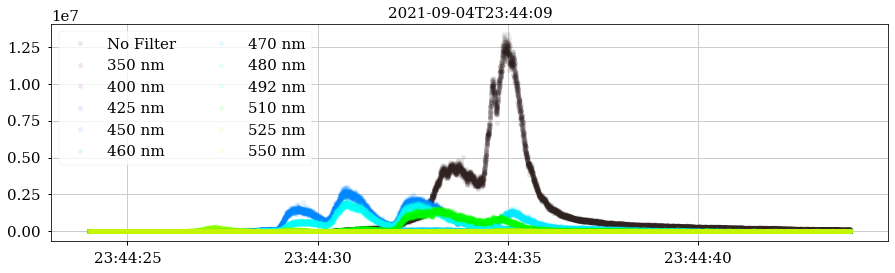

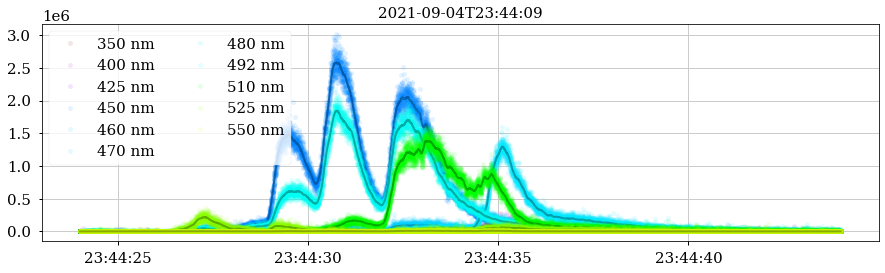

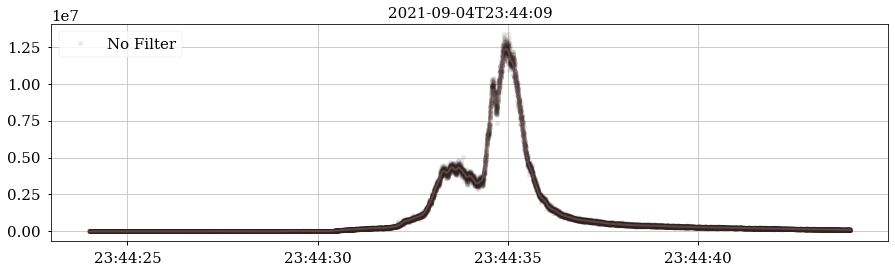

In [212]:
pmtspec, timestamp = pmt_specs[0], selected_timestamps[0]

pmtspec.pmt_meta_data.add_colors(
    plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
)

times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
### select +-2min around biolumi events
timemask = times_ns >= timestamp + np.timedelta64(15, "s")
timemask &= times_ns <= timestamp + np.timedelta64(35, "s")
masked_times_ns = times_ns[timemask]

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=2, ncol=2)

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] != 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
    plt.plot(
        masked_times_ns,
        uniform_filter1d(
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]], size=filter_N
        ),
        color=change_color_ld(wavelength_to_rgb(ch, gamma=0.4), -0.2),
        lw=2,
        alpha=0.8,
    )
plt.legend(loc=2, ncol=2)

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
    plt.plot(
        masked_times_ns,
        uniform_filter1d(
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]], size=filter_N
        ),
        color=change_color_ld(wavelength_to_rgb(ch, gamma=0.4), +0.2),
        lw=2,
        alpha=0.8,
    )
plt.legend(loc=2, ncol=2)


# Find peaks and quantify

In [213]:
from scipy.signal import find_peaks

filter_N = 100


Text(0.5, 0, 'Time')

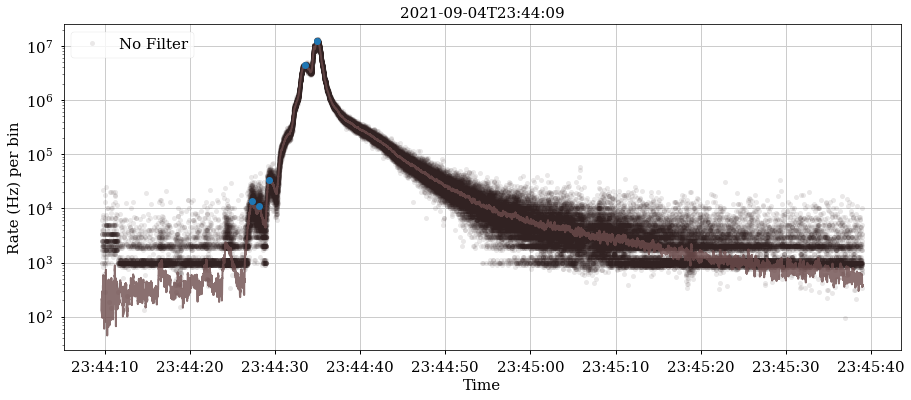

In [217]:
pmtspec, timestamp = pmt_specs[0], selected_timestamps[0]

pmtspec.pmt_meta_data.add_colors(
    plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
)

times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
timemask = times_ns >= timestamp + np.timedelta64(0, "s")
timemask &= times_ns <= timestamp + np.timedelta64(90, "s")
masked_times_ns = times_ns[timemask]

plt.figure(figsize=(15, 6))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
    smoothed_rate = uniform_filter1d(
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]], size=filter_N
    )
    plt.plot(
        masked_times_ns,
        smoothed_rate,
        color=change_color_ld(wavelength_to_rgb(ch, gamma=0.4), +0.2),
        lw=2,
        alpha=0.8,
    )
    peaks, prop = find_peaks(
        smoothed_rate,
        height=1e4,
        width=filter_N,
        distance=filter_N,
        rel_height=0.3
        # prominence=8E3
    )
    plt.plot(
        masked_times_ns[peaks], smoothed_rate[peaks], marker="o", lw=0, color="tab:blue"
    )
plt.legend(loc=2, ncol=2)
plt.semilogy()
plt.ylabel("Rate (Hz) per bin")
plt.xlabel("Time")

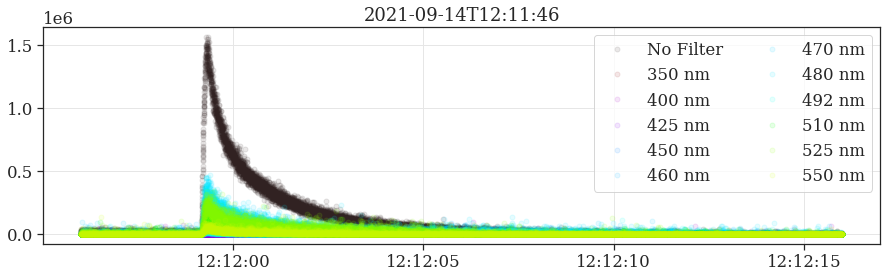

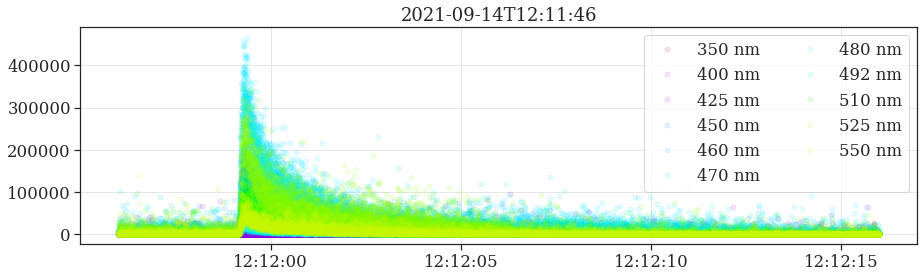

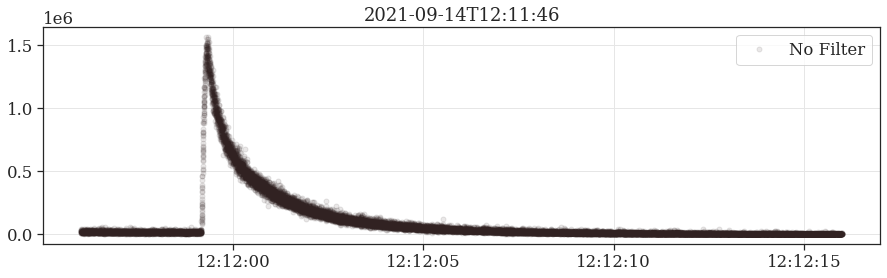

In [26]:
pmtspec, timestamp = pmt_specs[1], selected_timestamps[1]

pmtspec.pmt_meta_data.add_colors(
    plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
)

times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
### select +-2min around biolumi events
timemask = times_ns >= timestamp + np.timedelta64(10, "s")
timemask &= times_ns <= timestamp + np.timedelta64(30, "s")
masked_times_ns = times_ns[timemask]

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] != 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


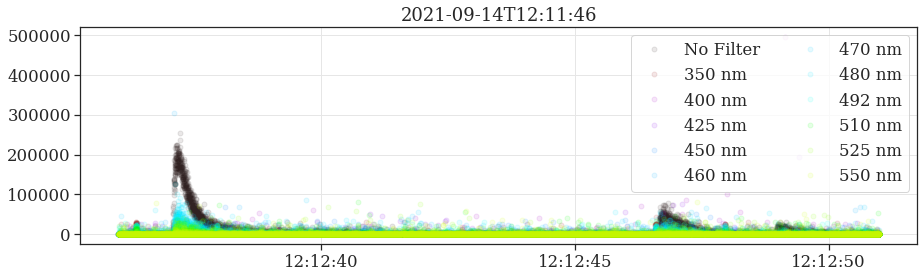

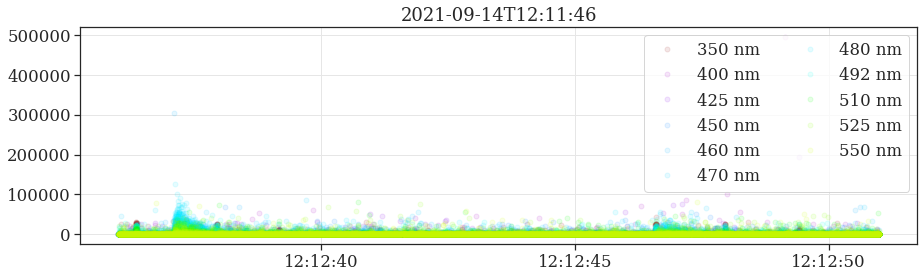

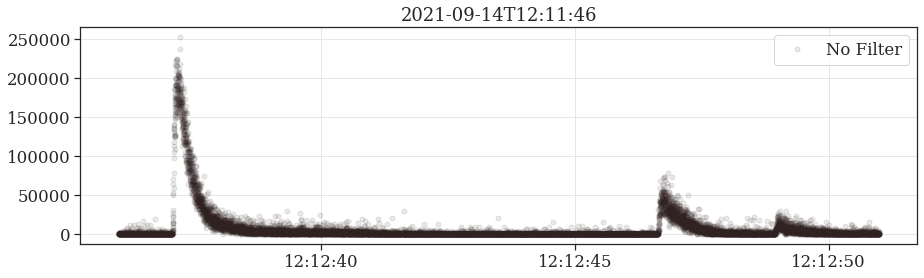

In [27]:
pmtspec, timestamp = pmt_specs[1], selected_timestamps[1]

pmtspec.pmt_meta_data.add_colors(
    plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
)

times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
### select +-2min around biolumi events
timemask = times_ns >= timestamp + np.timedelta64(50, "s")
timemask &= times_ns <= timestamp + np.timedelta64(65, "s")
masked_times_ns = times_ns[timemask]

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] != 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


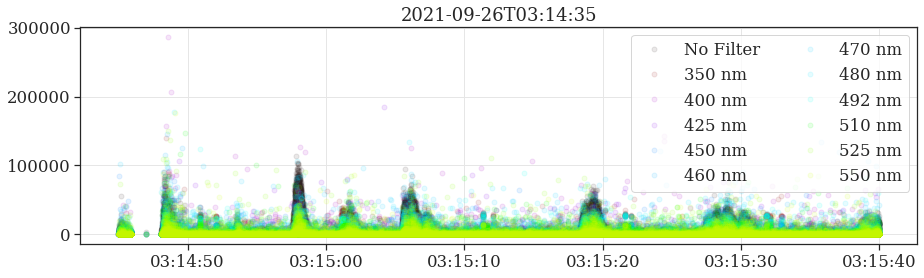

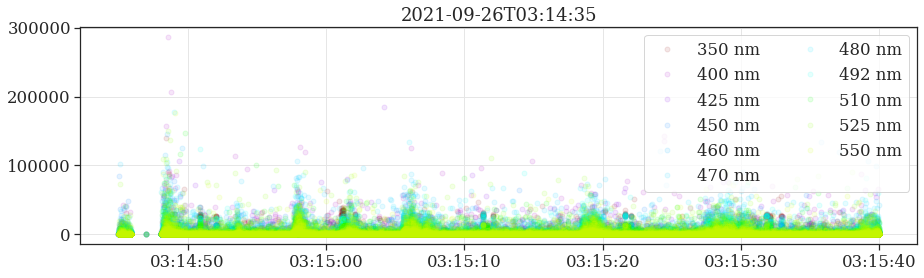

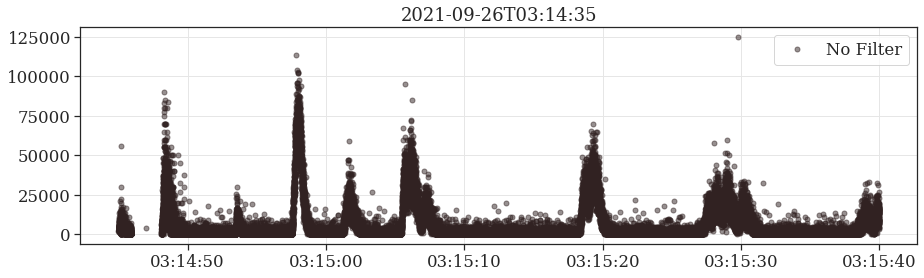

In [28]:
pmtspec, timestamp = pmt_specs[2], selected_timestamps[2]

pmtspec.pmt_meta_data.add_colors(
    plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
)

times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
### select +-2min around biolumi events
timemask = times_ns >= timestamp + np.timedelta64(10, "s")
timemask &= times_ns <= timestamp + np.timedelta64(65, "s")
masked_times_ns = times_ns[timemask]

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] != 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.5,
        ms=5,
    )
plt.legend(loc=1, ncol=2)
